In [6]:
#Import statements
import numpy as np
import pandas as pd
import cv2 as cv
import json
import os
from tqdm import tqdm
from sklearn import model_selection
import shutil

Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


In [21]:
#an = pd.read_json("trainval/annotations/bbox-annotations.json", orient='index')
path = "trainval/annotations/bbox-annotations.json"
f = open(path)
an = json.load(f)
print(an.keys())

dict_keys(['images', 'annotations', 'categories', 'licenses'])


In [8]:
an["categories"]

[{'id': 1, 'name': 'person', 'supercategory': 'none'},
 {'id': 2, 'name': 'car', 'supercategory': 'none'}]

In [9]:
an["licenses"]

[{'url': 'https://creativecommons.org/licenses/by/2.0/',
  'id': 1,
  'name': 'Attribution License'},
 {'url': 'https://creativecommons.org/licenses/by/4.0/',
  'id': 2,
  'name': 'Attribution License'}]

In [10]:
an["images"][0]

{'file_name': 'image_000000001.jpg',
 'width': 1024,
 'height': 768,
 'id': 0,
 'license': 1}

In [13]:
w = set()
h = set()

for img in an['images']:
    w.add(img["width"])
    h.add(img["height"])

print(w)

print(100*"-")

print(h)

{1024, 575, 576, 577, 590, 601, 629, 634, 642, 652, 666, 672, 674, 675, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 691, 694, 695, 697, 699, 700, 702, 703, 707, 710, 719, 720, 722, 724, 726, 727, 729, 730, 731, 734, 735, 738, 741, 742, 745, 751, 753, 758, 759, 765, 767, 768, 770, 772, 773, 774, 777, 779, 781, 787, 788, 791, 795, 798, 804, 807, 814, 816, 819, 835, 870, 873, 876, 882, 888, 890, 894, 904, 4496, 948, 960, 974, 975, 984, 992, 996, 1000, 1004, 1006, 1007, 1011, 1014}
----------------------------------------------------------------------------------------------------
{1024, 512, 515, 530, 531, 536, 542, 552, 559, 568, 569, 572, 574, 575, 576, 577, 579, 580, 581, 584, 585, 586, 588, 594, 595, 599, 601, 603, 606, 611, 612, 613, 614, 616, 617, 620, 621, 623, 625, 626, 630, 632, 633, 634, 635, 637, 638, 640, 641, 642, 643, 644, 645, 650, 651, 652, 655, 657, 658, 660, 661, 662, 664, 665, 666, 667, 669, 671, 672, 674, 675, 677, 678, 679, 680, 681, 682, 683, 684, 685

YOLOv5 expects all the images to be of a single dimension (ex 640 * 640). From above we can see that all the images are of different dimensions so I will resize them all to be of size 640 * 640.

In [64]:
img_path = "trainval/images/image_000000001.jpg"
img = cv.imread(img_path)

box = an["annotations"][0]["bbox"]
x = box[0]
y = box[1]
h = box[2]
w = box[3]

Checking out one of the bounding boxes

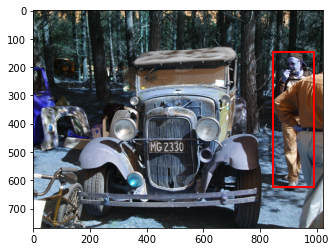

In [65]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

img_path = "trainval/images/image_000000001.jpg"
img = cv.imread(img_path)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(img)

# Create a Rectangle patch
rect = patches.Rectangle((x, y), h, w, linewidth=2, edgecolor='r', facecolor='none')


# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

Moving all annotations under one dataframe then splitting into train and validation

In [271]:
for i in range(0,5):
    print(annotations[i]["image_id"])
    print(annotations[i]["category_id"])
    print(annotations[i]["bbox"])
    print(10*"-------")

0
1
[1, 846, 145, 146, 477]
----------------------------------------------------------------------
0
1
[1, 848, 216, 175, 551]
----------------------------------------------------------------------
0
2
[2, 74, 159, 75, 81]
----------------------------------------------------------------------
0
2
[2, 153, 124, 658, 643]
----------------------------------------------------------------------
1
1
[1, 488, 281, 28, 71]
----------------------------------------------------------------------


In [22]:
#takes input as a json and fetches the image shape for the respective image_id

images = an["images"]

def get_image_shape(data, image_id):
    
    w = [img["width"] for img in data if img["id"] == image_id]
    h = [img["height"] for img in data if img["id"] == image_id]
    
    return w[0], h[0]


get_image_shape(images, 685)

(1024, 683)

In [262]:
annotations = an["annotations"] # bbox, category_id 
images = an["images"] # width and height of image

#[annotations(image_id) == images(id)]
#bbox with yolo format - category,x,y,width,height

df = pd.DataFrame(columns=["image_id","width","height","yolo_bbox"])


for annotation in annotations:
    row = []
    row.append(annotation["image_id"])
    width, height = get_image_shape(images, annotation["image_id"])
    row.append(width)
    row.append(height)
    yolo_bbox = annotation["bbox"]
    yolo_bbox.insert(0,annotation["category_id"])
    row.append(yolo_bbox)
    df.loc[len(df)] = row
    

print(df.head())
    

  image_id width height                yolo_bbox
0        0  1024    768  [1, 846, 145, 146, 477]
1        0  1024    768  [1, 848, 216, 175, 551]
2        0  1024    768     [2, 74, 159, 75, 81]
3        0  1024    768  [2, 153, 124, 658, 643]
4        1  1024    576    [1, 488, 281, 28, 71]


In [341]:
df.head()

,image_name,image_id,width,height,yolo_bbox
0,,0,1024,768,"[1, 846, 145, 146, 477]"
1,,0,1024,768,"[1, 848, 216, 175, 551]"
2,,0,1024,768,"[2, 74, 159, 75, 81]"
3,,0,1024,768,"[2, 153, 124, 658, 643]"
4,,1,1024,576,"[1, 488, 281, 28, 71]"


In [400]:
df_final = df.groupby(["image_id", "width", "height"])["yolo_bbox"].apply(list).reset_index(name="yolo_bboxes")

In [401]:
df_final.head()

,image_id,width,height,yolo_bboxes
0,0,1024,768,"[[1, 846, 145, 146, 477], [1, 848, 216, 175, 5..."
1,1,1024,576,"[[1, 488, 281, 28, 71], [2, 26, 283, 145, 75],..."
2,2,1024,683,"[[1, 8, 0, 80, 609], [1, 57, 32, 151, 256], [1..."
3,3,1024,675,"[[1, 454, 188, 104, 117], [2, 112, 139, 796, 4..."
4,4,1024,926,"[[1, 221, 718, 52, 122], [1, 305, 766, 61, 113..."


In [402]:
df_final.insert(0, "image_name", "", False)

In [403]:
df_final.head()

,image_name,image_id,width,height,yolo_bboxes
0,,0,1024,768,"[[1, 846, 145, 146, 477], [1, 848, 216, 175, 5..."
1,,1,1024,576,"[[1, 488, 281, 28, 71], [2, 26, 283, 145, 75],..."
2,,2,1024,683,"[[1, 8, 0, 80, 609], [1, 57, 32, 151, 256], [1..."
3,,3,1024,675,"[[1, 454, 188, 104, 117], [2, 112, 139, 796, 4..."
4,,4,1024,926,"[[1, 221, 718, 52, 122], [1, 305, 766, 61, 113..."


In [404]:
#adding image name to df_final

for image in images:
    image_name = image["file_name"]
    image_id = image["id"]
    df_final.iat[image_id, 0]= str(image_name)
    

In [405]:
df_final.tail()

,image_name,image_id,width,height,yolo_bboxes
2234,image_000002235.jpg,2234,1024,683,"[[2, 709, 86, 105, 80], [1, 0, 222, 56, 107], ..."
2235,image_000002236.jpg,2235,1024,683,"[[1, 623, 347, 84, 88], [2, 321, 377, 554, 284..."
2236,image_000002237.jpg,2236,682,1024,"[[1, 23, 136, 118, 135], [2, 38, 111, 580, 896..."
2237,image_000002238.jpg,2237,1024,683,"[[1, 298, 168, 392, 381], [1, 380, 4, 78, 42],..."
2238,image_000002239.jpg,2238,1024,685,"[[1, 192, 137, 30, 47], [1, 474, 171, 132, 244..."


In [406]:
df_final["image_name"] = df_final["image_name"].astype(str)

Train test split 

In [426]:
df_train, df_valid = model_selection.train_test_split(df_final, test_size=0.15, random_state=42, shuffle=True)

In [427]:
df_train.reset_index(inplace=True, drop=True)
df_valid.reset_index(inplace=True, drop=True)

In [428]:
df_train.shape

(1903, 5)

In [429]:
df_valid.shape

(336, 5)

In [442]:
df_train.head(10)

,image_name,image_id,width,height,yolo_bboxes
0,image_000000768.jpg,767,1024,768,"[[1, 0, 444, 39, 33], [1, 50, 410, 19, 30], [1..."
1,image_000000675.jpg,674,1024,683,"[[1, 317, 230, 180, 422], [2, 0, 172, 1023, 51..."
2,image_000000220.jpg,219,1024,768,"[[1, 136, 0, 56, 86], [1, 531, 0, 91, 272], [2..."
3,image_000000938.jpg,937,1024,683,"[[1, 0, 288, 85, 348], [2, 95, 112, 646, 474],..."
4,image_000001958.jpg,1957,1024,768,"[[1, 418, 577, 58, 178], [2, 730, 602, 140, 10..."
5,image_000001754.jpg,1753,683,1024,"[[1, 35, 72, 109, 322], [2, 143, 348, 535, 675]]"
6,image_000001655.jpg,1654,1024,683,"[[1, 170, 378, 64, 110], [2, 447, 322, 461, 20..."
7,image_000000213.jpg,212,1024,679,"[[1, 0, 0, 127, 450], [1, 34, 16, 617, 662], [..."
8,image_000001691.jpg,1690,768,1024,"[[2, 667, 667, 92, 79], [1, 38, 655, 147, 260]..."
9,image_000001567.jpg,1566,1024,677,"[[1, 699, 460, 50, 143], [2, 167, 452, 433, 21..."


In [420]:
type(df_final["image_name"][0])

str

In [472]:

#resizing images to 640*640 to fit yolo

from PIL import Image                                              
import os, sys           

SCALE_SIZE = 640 #resized image size
IMAGE_PATH = "trainval/images/"

dirs = os.listdir(IMAGE_PATH)                                       

'''
Since all the images are of different sizes and yolov5 expects all the images in a single size,
this function resizes all the images to 640*640. 
'''

def resize():
    for item in dirs:
        if os.path.isfile(IMAGE_PATH+item):
            im = Image.open(IMAGE_PATH+item)
            f, e = os.path.splitext(IMAGE_PATH+item)
            imResize = im.resize((SCALE_SIZE,SCALE_SIZE), Image.ANTIALIAS)
            imResize.save(f+'.jpg', 'jpeg', quality=90)

resize()

In [474]:
INPUT_PATH = "/home/raghav/Desktop/eagleView/trainval/images/"
OUTPUT_PATH = "/home/raghav/Desktop/eagleView/eagle_data/"
IMAGE_SIZE = 640.0


'''
This function takes in a dataframe and converts it into the yolov5 label format.
The yolov5 label format contains a txt file for every image.
Every label contains the data in the following format:
    5 numbers where the 1st number is the class of the object and
    the other 4 numbers are the bounding box coordinates normalized according to the yolov5 format.
(more details can be found on the yolov5 documentation page()https://docs.ultralytics.com/tutorials/train-custom-datasets/)
'''

def process_data(data, data_type="train"):
    
    for _,row in tqdm(data.iterrows(), total=len(data)):
        im_name = row["image_name"]
        im_name = im_name.replace(".jpg", "")
        bounding_boxes = row["yolo_bboxes"]
        yolo_data = []
        for bbox in bounding_boxes:
            category = bbox[0]
            category -= 1 # since yolo takes class_ids starting from 0
            x = bbox[1]
            y = bbox[2]
            w = bbox[3]
            h = bbox[4]
            
            #scaling values according to the new image size
            x *= IMAGE_SIZE/row["width"]
            y *= IMAGE_SIZE/row["height"]
            w *= IMAGE_SIZE/row["width"]
            h *= IMAGE_SIZE/row["height"]
            
            
            #now scaling values according to yolo format
            x_center = x + w/2
            y_center = y + h/2
            x_center /= IMAGE_SIZE
            y_center /= IMAGE_SIZE
            w /= IMAGE_SIZE
            h /= IMAGE_SIZE
            
            yolo_data.append([category, x_center, y_center, w, h])
        
        yolo_data = np.array(yolo_data)
        np.savetxt(
            os.path.join(OUTPUT_PATH, f"labels/{data_type}/{im_name}.txt"),
            yolo_data,
            fmt = ["%d","%f","%f","%f","%f"]
        )


        shutil.copyfile(
            os.path.join(INPUT_PATH, f"{im_name}.jpg"),
            os.path.join(OUTPUT_PATH, f"images/{data_type}/{im_name}.jpg")
        )

        
process_data(df_train, "train")
process_data(df_valid, "validation")

print("Train and validation data processing complete.")

100%|██████████| 336/336 [00:00<00:00, 1049.14it/s]

Train and validation data processing complete.


In [489]:
cd yolov5/

/home/raghav/Desktop/eagleView/yolov5


### I ran the command below in a terminal as the notebook got hanged when I ran it here. 

In [ ]:
!python train.py --img 640 --batch 8 --epochs 10 --data ../data.yaml --weights yolov5s.pt --device 0  --name eagle_s_model

### For running our trained model for testing out on images, videos etc, we can use the below command:
(we should be inside the yolov5 cloned repository)

In [ ]:
!python detect.py --weights path_to_weights --source path_to_test_files